## Notebook to show behavior of each ant as a function of time
We would like to build an array of the enter and leave time for each ant.
We would also like to rank order.
Then color code it as to which nest is being entered as well as a background color corresponding to which role the ant is grouped in.

Analyzing colony 3004 treatment 1
Time of Max LAI [s]: 40106
Import Success!


Length of Trial [min]: 769.116666667


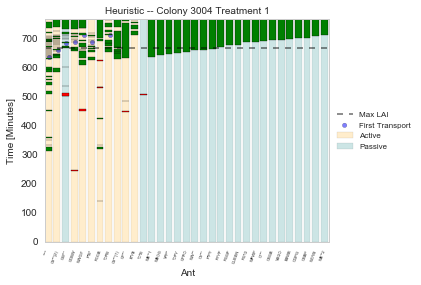

Done.
Analyzing colony 3004 treatment 2
Time of Max LAI [s]: 12960
Import Success!


Length of Trial [min]: 770.45


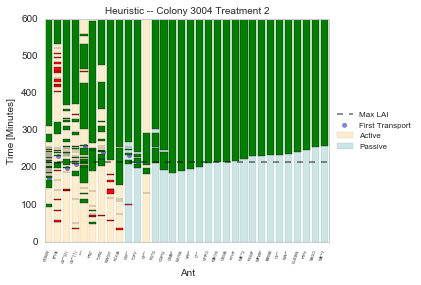

Done.
Analyzing colony 3004 treatment 3
Time of Max LAI [s]: 9927
Import Success!


Length of Trial [min]: 294.816666667


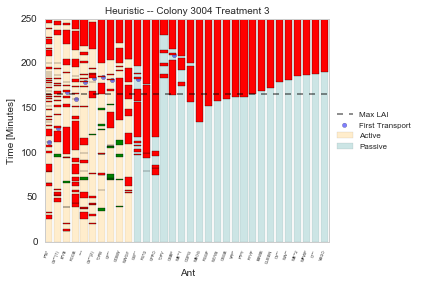

Done.
Analyzing colony 3004 treatment 4
Time of Max LAI [s]: 32819
Import Success!


Length of Trial [min]: 606.133333333


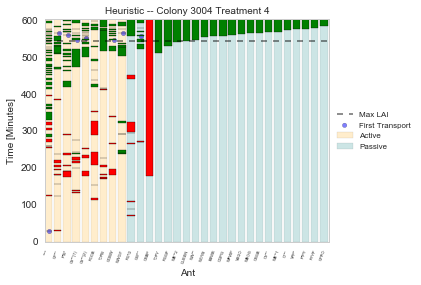

Done.
Analyzing colony 3004 treatment 5
Time of Max LAI [s]: 11604
Import Success!


Length of Trial [min]: 260.85


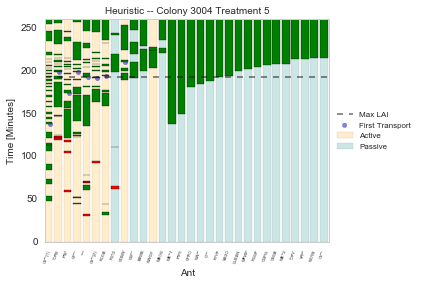

Done.


In [92]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter

%matplotlib inline

# Specify Treatment Info
#col_id = '6'
#col_id = '208'
col_id = '3004'
treatment_array = [1,2,3,4,5]
#treatment_array = [5]
n_clusters = 2

# Store max local info for plotting
LAI = {'6':[19300,13859,38333,8479,9542],'208':[np.nan,8342,10478,5839,2932],'3004':[40106,12960,9927,32819,11604]}

# Store max time we would like to display (y_max) for plotting
MAX_TIME = {'6':{1:500,2:0,3:0,4:0,5:250},'208':{2:640,3:700,4:200,5:0},'3004':{1:0,2:600,3:250,4:0,5:0}}

# Store bad ants with coding errors (more on this in the cell below)
BAD_ANTS = {'6':{1:[],2:[],3:[],4:[],5:[]},'208':{2:[],3:['GBLO'],4:[],5:[]},'3004':{1:[],2:[],3:[],4:[],5:[]}}

## Build Ethograms
for treatment_id in treatment_array:
    
    print 'Analyzing colony',col_id,'treatment',treatment_id
    max_lai = 0
    max_lai = LAI[col_id][treatment_id-1]
    if max_lai > 0:
        print 'Time of Max LAI [s]:',max_lai
    else:
        print 'ERROR: Max LAI not defined'
    
    # Get colony roles and store as dict
    path = '/Users/jakehanson/Documents/Ants/Nest_Choice/Ethogram/Final_Clustering/data/kmeans_high_level/colony'+\
    col_id+'Nclusters'+str(n_clusters)+'treatment'+str(treatment_id)+'.kmeans.hl.txt'
    roles = pd.read_table(path,sep='\s')
    n_ants = np.shape(roles)[0]
    role_dict = {}
    for i in range(0,n_ants):
        role_dict[roles['colorId'][i]]=roles['role'][i]

    # Get emigration data and sort
    path = '/Users/jakehanson/Documents/Ants/Nest_Choice/Improved_Treatments/Separate_Treatments/col' \
            +str(col_id)+'_treatment'+str(treatment_id)+'.csv'
    data = pd.DataFrame.from_csv(path,index_col=False)
    data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.time
    if data.empty == False:
        print 'Import Success!\n\n'
    else:
        print 'ERROR!!! Data Frame is empty for colony',col_id,'treatment',treatment_id    
    data = data.sort(['Ant','Time'],ascending=True)  # Sort by ant
    n_rows = np.shape(data)[0]
    data.index = np.arange(n_rows)  # Reindex accordingly

    # Get length of trial
    max_time = 0
    for i in range(n_rows):
        strip_time = time.strptime(str(data['Time'][i]),'%H:%M:%S')
        new_time = strip_time.tm_hour*60*60+strip_time.tm_min*60+strip_time.tm_sec
        new_time = new_time/60.

        if new_time > max_time:
            max_time = new_time
    print 'Length of Trial [min]:',max_time

    # Initialize
    ethogram = {}  # initialize empty dict to store the name of each ant and an array with important info
    old_ant = data['Ant'][0] # initialize which ant we are on
    counter = 1
    in_nest = False

    ethogram[old_ant] = [[0],[],[]]  # initialize first key with time of 0 and empty array for location
    ## First list is for the entry and exit times
    ## Second list is for which nest she is in
    ## Third list is for times of completed transports

    
    # Build ethograms
    for i in range(0,n_rows):
        new_ant = data['Ant'][i]
        if new_ant != old_ant and new_ant != 'OldUncoded':
            # Check if the previous ant never left
            if in_nest == True:
                ethogram[old_ant][0].append(max_time)            
            # Reset and initialize
            in_nest = False  # All ants start outside of nest
            counter = counter + 1
            old_ant = new_ant
            ethogram[new_ant] = [[0],[],[]]

        # Enter Nest (E), Carried into Nest (BC), Transport In (TB,TU,TA)
        if data['Behavior'][i] == 'E' or data['Behavior'][i] == 'BC' or \
        data['Behavior'][i] == 'TB' or data['Behavior'][i] == 'TU' or data['Behavior'][i] == 'TA':
            if in_nest == True:
                print 'ERROR: Ant',new_ant,'Entered Nest without having left (',data['Behavior'][i-1],'->',data['Behavior'][i],') at time',data['Time'][i]
            in_nest = True
                
            nest_site = data['Location/Origin'][i]

            # Get entry time
            strip_time = time.strptime(str(data['Time'][i]),'%H:%M:%S')
            entry_time = strip_time.tm_hour*60*60+strip_time.tm_min*60+strip_time.tm_sec
            entry_time = entry_time/60.  # convert to minutes
            ethogram[new_ant][0].append(entry_time)
            ethogram[new_ant][1].append(nest_site)

            # Special line for transports
            if data['Behavior'][i] == 'TB' or data['Behavior'][i] == 'TU' or data['Behavior'][i] == 'TA':
                ethogram[new_ant][2].append(entry_time)
            

        # Leave on own free accord
        if data['Behavior'][i] == 'L' or data['Behavior'][i] == 'TAO' or \
        data['Behavior'][i] == 'TBO' or data['Behavior'][i] == 'BCO': 
            if in_nest == False:
                print 'ERROR: Ant',new_ant,'Left Nest without having entered (',data['Behavior'][i-1],'->',data['Behavior'][i],') at time',data['Time'][i]
                in_nest = False
            else:
                in_nest = False

            # Get exit time
            strip_time = time.strptime(str(data['Time'][i]),'%H:%M:%S')
            exit_time = strip_time.tm_hour*60*60+strip_time.tm_min*60+strip_time.tm_sec
            exit_time = exit_time/60.
            delta_time = exit_time - entry_time
            if delta_time <= 0:
                print 'ERROR: Non-positive time spent in nest!!!!!!!!!!!!!!!'
                # Raise a flag that makes the data not included
            else:
                ethogram[new_ant][0].append(exit_time)
                ethogram[new_ant][1].append(nest_site)

    # If the last ant ended inside the nest, make sure we append the final time
    if in_nest == True:
        ethogram[new_ant][0].append(max_time)   
        
    # Remove bad ants from data
    for bad_ant in BAD_ANTS[col_id][treatment_id]:
        print 'Ant',bad_ant,'has been removed'
        ethogram.pop(bad_ant,None)
        role_dict.pop(bad_ant,None)
        
    ## BEGIN PLOT
    sns.set_style("whitegrid",{'axes.grid' : False})
    
    # Create a dict with the rank order for each ant
    temp_list = []
    for i in range(np.size(ethogram.keys())):
        if np.size(ethogram[ethogram.keys()[i]][0]) > 1:
            temp_list.append([ethogram.keys()[i],np.size(ethogram[ethogram.keys()[i]][0]),ethogram[ethogram.keys()[i]][0][1]])
        else:
            temp_list.append([ethogram.keys()[i],np.size(ethogram[ethogram.keys()[i]][0]),ethogram[ethogram.keys()[i]][0]])

    # Sort
    index_2 = 'Entry_Time'
    index_1 = 'Freq'
    if index_1 == 'Entry_Time' and index_2 == 'Freq':
        ranked_list = sorted(temp_list,key=itemgetter(1),reverse=True)
        ranked_list = sorted(ranked_list,key=itemgetter(2),reverse=False)
        rank_dict = {}
        counter = 0
        for each in ranked_list:
            rank_dict[each[0]] = counter
            counter = counter + 1
    elif index_2 == 'Entry_Time' and index_1 == 'Freq':
        ranked_list = sorted(temp_list,key=itemgetter(2),reverse=False)
        ranked_list = sorted(ranked_list,key=itemgetter(1),reverse=True)
        rank_dict = {}
        counter = 0
        for each in ranked_list:
            rank_dict[each[0]] = counter
            counter = counter + 1

    ## Make Bar Plot
    fig = plt.figure()
    ax = plt.subplot(111)

    # Create lists to store which ants belong to which clustering result
    counter = 0
    x_locations = []  # list to store the order of locations
    active_ants = []  # cluster result 1 
    passive_ants = []  # cluster result 2


    # Plot background color
    for i in ethogram.keys():
        location = rank_dict[i]
        x_locations.append(location)
        if role_dict[i] == 'active':
            active_ants.append(location)
        elif role_dict[i] == 'passive':
            passive_ants.append(location)
        for j in range(0,np.size(ethogram[i][0])-1):
            if (j+1)%2 == 0:  # every other j we are at a new place
                nest_site = ethogram[i][1][j-1]
                alphaz = 1.0
                if nest_site == 'good':
                    colorz = 'green'
                else:
                    colorz = 'red'
            else:
                colorz = 'white'
                alphaz = 0.0
            height = ethogram[i][0][j+1] - ethogram[i][0][j]
            ax.bar(location,height,color=colorz,alpha=alphaz,bottom=ethogram[i][0][j],zorder=1)
        counter = counter + 1
    # If cluster lists are non-empty, plot them
    if active_ants:
        ax.bar(active_ants,[max_time]*np.size(active_ants),color='orange',alpha=0.2,bottom=0.,label='Active',zorder=-1)
    if passive_ants:
        ax.bar(passive_ants,[max_time]*np.size(passive_ants),color='teal',alpha=0.2,bottom=0.,label='Passive',zorder=-1)

    # Plot of first TR and Transport
    names_of_transporters = []
    times_of_transports = []
    for each in ethogram.keys():
        # if they had a transport record it
        if ethogram[each][2]:
            names_of_transporters.append(rank_dict[each]+0.5)
            times_of_transports.append(ethogram[each][2][0])
    ax.scatter(names_of_transporters,times_of_transports,alpha=0.5,label='First Transport')
    
    # Clean up Plot
    plt.ylabel('Time [Minutes]',size=10)
    plt.xlabel('Ant',size=10)
    plt.xlim((0,np.size(ethogram.keys())))
    ax.axhline(max_lai/60.,color='black',alpha=0.5,linestyle='--',label='Max LAI')
    if MAX_TIME[col_id][treatment_id] != 0:
        plt.ylim(0,MAX_TIME[col_id][treatment_id])
    else:
        plt.ylim(0,max_time)
    plt.xticks(x_locations+np.asarray(0.25), ethogram.keys(),rotation=70,size=4)
    plt.title('Heuristic -- Colony '+str(col_id)+' Treatment '+ \
              str(treatment_id) ,size=10)
    # Shrink current axis
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=8)
    #plt.tight_layout()
    plt.savefig('/Users/jakehanson/Documents/Ants/Nest_Choice/Ethogram/Final_Clustering/kmeans_heuristic/col'+str(col_id)+'_t'+str(treatment_id)+'.pdf')
    plt.show()

    print 'Done.'

## Notes about coding errors:
- Col 6 t1: Coding errors only showed up above the max time, so are not visible in these ethograms
- Col 6 t5: **** had an L (2:21:18) followed by an L (2:25:06). Former was removed from data.
- Col 6 t5: **** had a TA->TA but it occured after the max time, so it was ignored.
- Col 208 t2: GOYL had L->BCO but it occured after the max time, so it was ignored.
- Col 208 t3: GGYO had an FB followed by L. I assumed FB was E
- Col 208 t3: GBLO had L to BCO that could not be resolved. Ant was removed from data.
- Col 3004 t1: **** (very active ant) had TB without an L (11:40:16). The average time for an L after a TB was calcuted using the prior and following TB/L pairs and inserted at the resulting time (11:41:06).
- Col 3004 t2: **** (very active ant) had E (4:33:20) followed by E (5:04:18). Former was removed from data.
- Col 3004 t3: **** (very active ant) had L (56:01) followed by L (1:07:32). Latter was removed from data.
- Col 3004 t3: **** (very active ant) had E (2:41:14) followed by E (2:53:43). Former was removed from data.
- Col 3004 t3: **** (very active ant) had TB (3:02:05) followed by FB (3:03:36). L was added 13s after FB, to complete the TB->FB->L motif that immediately proceeds this behavior.